### Importing libraries and data

In [2]:
# !pip install lightgbm
# !pip install seaborn --upgrade

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pickle
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier, plot_importance as plot_importance_lgbm

import re
from scipy import stats
from tqdm import tqdm
import glob
import time

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_curve, auc, roc_auc_score, precision_recall_curve

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from utils import (clean_text, calculate_churn_risk_score, map_target_data, preprocess_data, calculate_churn_risk_score, 
    select_train_data, load_all_feature_names, scale_test_data, load_models, 
    load_model_params, tune_model, train_models, evaluate_model)

#### Functions

In [3]:
def load_train_feature_sets():
    
    train_feature_sets = {
        '[X_tr_imb, y_tr_imb]' : [X_tr_imb, y_tr_imb], 
        '[X_tr_imb_std, y_tr_imb]' : [X_tr_imb_std, y_tr_imb],
        '[X_tr_imb_minmax, y_tr_imb]' : [X_tr_imb_minmax, y_tr_imb],
        '[X_tr_smote, y_tr_smote]' : [X_tr_smote, y_tr_smote],
        '[X_tr_smote_std, y_tr_smote]' : [X_tr_smote_std, y_tr_smote],
        '[X_tr_smote_minmax, y_tr_smote]' : [X_tr_smote_minmax, y_tr_smote],
        '[X_tr_adasyn, y_tr_adasyn]' : [X_tr_adasyn, y_tr_adasyn],
        '[X_tr_adasyn_std, y_tr_adasyn]' : [X_tr_adasyn_std, y_tr_adasyn],
        '[X_tr_adasyn_minmax, y_tr_adasyn]' : [X_tr_adasyn_minmax, y_tr_adasyn]
    }

    return train_feature_sets


def load_test_feature_sets():
    
    test_feature_sets = {
        '[X_te_imb, y_te_imb]' : [X_te_imb, y_te_imb],
        '[X_te_imb_std, y_te_imb]' : [X_te_imb_std, y_te_imb],
        '[X_te_imb_minmax, y_te_imb]' : [X_te_imb_minmax, y_te_imb],
        '[X_te_smote_std, y_te_smote]' : [X_te_smote_std, y_te_smote],
        '[X_te_smote_minmax, y_te_smote]' : [X_te_smote_minmax, y_te_smote],
        '[X_te_adasyn_std, y_te_adasyn]' : [X_te_adasyn_std, y_te_adasyn],
        '[X_te_adasyn_minmax, y_te_adasyn]' :  [X_te_adasyn_minmax, y_te_adasyn]   
    }

    return test_feature_sets

#### Feature sets for train data

There are 9 different feature sets prepared at preprocessing step.

Combination of imbalanced, smote balanced and adasyn balanced with that of unscaled, standard scaled and min-max scaled

In [6]:
# allowed_samples = ['None', 'smote', 'adasyn']
# allowed_scales = ['None', 'standard', 'minmax']

X_tr_imb, y_tr_imb = select_train_data('None', 'None')
X_tr_imb_std, y_tr_imb = select_train_data('None', 'standard')
X_tr_imb_minmax, y_tr_imb = select_train_data('None', 'minmax')

X_tr_smote, y_tr_smote = select_train_data('smote', 'None')
X_tr_smote_std, y_tr_smote = select_train_data('smote', 'standard')
X_tr_smote_minmax, y_tr_smote = select_train_data('smote', 'minmax')

X_tr_adasyn, y_tr_adasyn = select_train_data('adasyn', 'None')
X_tr_adasyn_std, y_tr_adasyn = select_train_data('adasyn', 'standard')
X_tr_adasyn_minmax, y_tr_adasyn = select_train_data('adasyn', 'minmax')

In [7]:
# train feature sets

train_feature_sets = load_train_feature_sets()
len(train_feature_sets)

9

#### Feature sets for test data

In [9]:
with open(r'.\data_for_model\test\test_data.pkl', 'rb') as f:
    X_test, y_test = pickle.load(f)

X_test.shape, y_test.shape

((1407, 19), (1407,))

In [10]:
y_te_imb = map_target_data(y_test)
X_te_imb = preprocess_data(X_test)
X_te_imb.head(2)

,tenure,MonthlyCharges,TotalCharges,Charges_to_tenure_ratio,Charges_to_tenure_ratio_transformed,tenure_transformed,MonthlyCharges_transformed,TotalCharges_transformed,New_Churn_Risk_Score,gender,...,PaymentMethod_bank_transfer,PaymentMethod_credit_card,PaymentMethod_electronic_check,PaymentMethod_mailed_check,New_tenure_Year_0_1_Year,New_tenure_Year_1_2_Year,New_tenure_Year_2_3_Year,New_tenure_Year_3_4_Year,New_tenure_Year_4_5_Year,New_tenure_Year_5_6_Year
0,59,75.95,4542.35,1.287288,-0.671003,0.783330,0.179102,0.852786,2,0,...,0,1,0,0,0,0,0,0,1,0
1,7,78.55,522.95,11.221429,0.941908,-0.798769,0.215679,-0.561638,7,0,...,1,0,0,0,1,0,0,0,0,0


In [11]:
# allowed_samples = ['smote', 'adasyn']
# allowed_scales = ['standard', 'minmax']

X_te_imb_std, y_te_imb = scale_test_data('None', 'standard', data=[X_te_imb, y_te_imb])
X_te_imb_minmax, y_te_imb =  scale_test_data('None', 'minmax', data=[X_te_imb, y_te_imb])

X_te_smote_std, y_te_smote = scale_test_data('smote', 'standard', data=[X_te_imb, y_te_imb])
X_te_smote_minmax, y_te_smote = scale_test_data('smote', 'minmax', data=[X_te_imb, y_te_imb])

X_te_adasyn_std, y_te_adasyn = scale_test_data('adasyn', 'standard', data=[X_te_imb, y_te_imb])
X_te_adasyn_minmax, y_te_adasyn = scale_test_data('adasyn', 'minmax', data=[X_te_imb, y_te_imb])

In [12]:
# test feature sets

test_feature_sets = load_test_feature_sets()

len(test_feature_sets)

7

#### Training Models

In [27]:
%%time
random.seed(42)
results = []
results += train_models('[X_tr_imb, y_tr_imb]', '[X_te_imb, y_te_imb]', train_feature_sets, test_feature_sets)
results += train_models('[X_tr_imb_std, y_tr_imb]', '[X_te_imb_std, y_te_imb]', train_feature_sets, test_feature_sets)
results += train_models('[X_tr_imb_minmax, y_tr_imb]', '[X_te_imb_minmax, y_te_imb]', train_feature_sets, test_feature_sets)

results += train_models('[X_tr_smote, y_tr_smote]', '[X_te_imb, y_te_imb]', train_feature_sets, test_feature_sets)
results += train_models('[X_tr_smote_std, y_tr_smote]', '[X_te_smote_std, y_te_smote]', train_feature_sets, test_feature_sets)
results += train_models('[X_tr_smote_minmax, y_tr_smote]', '[X_te_smote_minmax, y_te_smote]', train_feature_sets, test_feature_sets)

results += train_models('[X_tr_adasyn, y_tr_adasyn]', '[X_te_imb, y_te_imb]', train_feature_sets, test_feature_sets)
results += train_models('[X_tr_adasyn_std, y_tr_adasyn]', '[X_te_adasyn_std, y_te_adasyn]', train_feature_sets, test_feature_sets)
results += train_models('[X_tr_adasyn_minmax, y_tr_adasyn]', '[X_te_adasyn_minmax, y_te_adasyn]', train_feature_sets, test_feature_sets)

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:09<00:01,  1.97s/it]

[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1775
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:10<00:02,  2.11s/it]

[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1776
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:09<00:01,  1.92s/it]

[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1773
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:24<00:04,  4.53s/it]

[LightGBM] [Info] Number of positive: 4130, number of negative: 4130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1956
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:14<00:03,  3.01s/it]

[LightGBM] [Info] Number of positive: 4130, number of negative: 4130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1958
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:14<00:03,  3.08s/it]

[LightGBM] [Info] Number of positive: 4130, number of negative: 4130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1956
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:29<00:05,  5.39s/it]

[LightGBM] [Info] Number of positive: 4178, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1957
[LightGBM] [Info] Number of data points in the train set: 8308, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502889 -> initscore=0.011555
[LightGBM] [Info] Start training from score 0.011555


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:14<00:03,  3.07s/it]

[LightGBM] [Info] Number of positive: 4178, number of negative: 4130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1958
[LightGBM] [Info] Number of data points in the train set: 8308, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502889 -> initscore=0.011555
[LightGBM] [Info] Start training from score 0.011555


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:13<00:02,  2.85s/it]

[LightGBM] [Info] Number of positive: 4178, number of negative: 4130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1956
[LightGBM] [Info] Number of data points in the train set: 8308, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502889 -> initscore=0.011555
[LightGBM] [Info] Start training from score 0.011555


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.44s/it]

CPU times: total: 2min
Wall time: 2min 29s


In [28]:
results_df = pd.DataFrame(results)
results_df.sort_values(by=['test_f1_micro','test_f1_macro','test_f1_weighted'], ascending=[False, False, False], inplace=True)
results_df

,Model,train_data,test_data,train_f1_micro,test_f1_micro,train_f1_macro,test_f1_macro,train_f1_weighted,test_f1_weighted
0,Logistic Regression,"[X_tr_imb, y_tr_imb]","[X_te_imb, y_te_imb]",0.8064,0.8045,0.7350,0.7362,0.7994,0.7991
12,Logistic Regression,"[X_tr_imb_minmax, y_tr_imb]","[X_te_imb_minmax, y_te_imb]",0.8110,0.8024,0.7396,0.7336,0.8035,0.7970
6,Logistic Regression,"[X_tr_imb_std, y_tr_imb]","[X_te_imb_std, y_te_imb]",0.8105,0.7989,0.7399,0.7280,0.8034,0.7930
48,Logistic Regression,"[X_tr_adasyn_minmax, y_tr_adasyn]","[X_te_adasyn_minmax, y_te_adasyn]",0.8616,0.7982,0.8616,0.7423,0.8616,0.7985
30,Logistic Regression,"[X_tr_smote_minmax, y_tr_smote]","[X_te_smote_minmax, y_te_smote]",0.8608,0.7974,0.8607,0.7390,0.8607,0.7968
24,Logistic Regression,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_te_smote]",0.8607,0.7960,0.8606,0.7385,0.8606,0.7959
8,SVC,"[X_tr_imb_std, y_tr_imb]","[X_te_imb_std, y_te_imb]",0.8194,0.7953,0.7431,0.7138,0.8087,0.7853
42,Logistic Regression,"[X_tr_adasyn_std, y_tr_adasyn]","[X_te_adasyn_std, y_te_adasyn]",0.8621,0.7946,0.8620,0.7371,0.8620,0.7947
5,LightGBM,"[X_tr_imb, y_tr_imb]","[X_te_imb, y_te_imb]",0.8921,0.7861,0.8563,0.7124,0.8899,0.7806
14,SVC,"[X_tr_imb_minmax, y_tr_imb]","[X_te_imb_minmax, y_te_imb]",0.8219,0.7861,0.7461,0.6966,0.8111,0.7738


**Observation:**

1. Logistic Regression looks promising
2. SVC, randomforest and lightgbm are other algos to try on certain feature sets
3. Also, we can see that macro score is dropping due to giving equal importance to both the majority and minority classes

#### Tuning top 10-12 models

In [42]:
%%time
random.seed(42)
results = []
results += train_models('[X_tr_imb, y_tr_imb]', '[X_te_imb, y_te_imb]', train_feature_sets, test_feature_sets, tune=True, scoring=['accuracy','f1'], models={'Logistic Regression': LogisticRegression(),
                                                                                                                                                             'Random Forest': RandomForestClassifier(),
                                                                                                                                                             'LightGBM': LGBMClassifier()})
results += train_models('[X_tr_imb_std, y_tr_imb]', '[X_te_imb_std, y_te_imb]', train_feature_sets, test_feature_sets, tune=True, scoring=['accuracy','f1'], models={'Logistic Regression': LogisticRegression(),
                                                                                                                                                                     'SVC': SVC()})
results += train_models('[X_tr_imb_minmax, y_tr_imb]', '[X_te_imb_minmax, y_te_imb]', train_feature_sets, test_feature_sets, tune=True, scoring=['accuracy','f1'], models={'Logistic Regression': LogisticRegression(),
                                                                                                                                                                           'SVC': SVC()})

results += train_models('[X_tr_smote_std, y_tr_smote]', '[X_te_smote_std, y_te_smote]', train_feature_sets, test_feature_sets, tune=True, scoring=['accuracy','f1'], models={'Logistic Regression': LogisticRegression(),
                                                                                                                                                                             'Random Forest': RandomForestClassifier(),
                                                                                                                                                                             'LightGBM': LGBMClassifier()})
results += train_models('[X_tr_smote_minmax, y_tr_smote]', '[X_te_smote_minmax, y_te_smote]', train_feature_sets, test_feature_sets, tune=True, scoring=['accuracy','f1'], models={'Logistic Regression': LogisticRegression()})

results += train_models('[X_tr_adasyn_std, y_tr_adasyn]', '[X_te_adasyn_std, y_te_adasyn]', train_feature_sets, test_feature_sets, tune=True, scoring=['accuracy','f1'], models={'Logistic Regression': LogisticRegression()})
results += train_models('[X_tr_adasyn_minmax, y_tr_adasyn]', '[X_te_adasyn_minmax, y_te_adasyn]', train_feature_sets, test_feature_sets, tune=True, scoring=['accuracy','f1'], models={'Logistic Regression': LogisticRegression()})

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 33%|████████████████████████████                                                        | 1/3 [00:08<00:16,  8.39s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:53<00:30, 30.01s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1775
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 50%|██████████████████████████████████████████                                          | 1/2 [00:05<00:05,  5.05s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 50%|██████████████████████████████████████████                                          | 1/2 [00:05<00:05,  5.73s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 33%|████████████████████████████                                                        | 1/3 [00:09<00:19,  9.78s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 67%|████████████████████████████████████████████████████████                            | 2/3 [01:22<00:46, 46.82s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Info] Number of positive: 4130, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1958
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [09:16<00:00, 185.56s/it]


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.86s/it]

CPU times: total: 3min 20s
Wall time: 19min 47s


In [47]:
results_df = pd.DataFrame(results)
results_df.sort_values(by=['test_f1_micro'], ascending=[False], inplace=True)
results_df

,Model,train_data,test_data,train_f1_micro,test_f1_micro,train_f1_macro,test_f1_macro,train_f1_weighted,test_f1_weighted
10,Logistic Regression,"[X_tr_smote_minmax, y_tr_smote]","[X_te_smote_minmax, y_te_smote]",0.8639,0.7989,0.8639,0.7394,0.8639,0.7977
5,Logistic Regression,"[X_tr_imb_minmax, y_tr_imb]","[X_te_imb_minmax, y_te_imb]",0.8103,0.7982,0.7405,0.7279,0.8035,0.7926
0,Logistic Regression,"[X_tr_imb, y_tr_imb]","[X_te_imb, y_te_imb]",0.8101,0.7974,0.7402,0.7267,0.8033,0.7918
2,LightGBM,"[X_tr_imb, y_tr_imb]","[X_te_imb, y_te_imb]",0.8272,0.7974,0.7613,0.7228,0.8201,0.7902
1,Random Forest,"[X_tr_imb, y_tr_imb]","[X_te_imb, y_te_imb]",0.8569,0.7967,0.8001,0.7175,0.8500,0.7876
3,Logistic Regression,"[X_tr_imb_std, y_tr_imb]","[X_te_imb_std, y_te_imb]",0.8103,0.7967,0.7406,0.7254,0.8036,0.7910
7,Logistic Regression,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_te_smote]",0.8631,0.7953,0.8630,0.7336,0.8630,0.7937
4,SVC,"[X_tr_imb_std, y_tr_imb]","[X_te_imb_std, y_te_imb]",0.8212,0.7932,0.7459,0.7086,0.8107,0.7821
11,Logistic Regression,"[X_tr_adasyn_std, y_tr_adasyn]","[X_te_adasyn_std, y_te_adasyn]",0.8654,0.7932,0.8654,0.7316,0.8654,0.7918
12,Logistic Regression,"[X_tr_adasyn_minmax, y_tr_adasyn]","[X_te_adasyn_minmax, y_te_adasyn]",0.8651,0.7932,0.8650,0.7316,0.8650,0.7918


**Observation:**

  
    1. We can see that Logistic regression with smote upsampled minmax scaled is the top model. However, it slightly overfits compared to logistic regression with imbalanced minmax scaled data.
    2. Also, macor-f1 on test data is slightly higher for smote upsampled minmax scaled data

Below is the illustration of 1st model

In [51]:
models = load_models()
model_params = load_model_params()

model = models['Logistic Regression']
param_grid = model_params['Logistic Regression']

In [55]:
best_model, best_score = tune_model('grid', model, param_grid, X_tr_smote_minmax, y_tr_smote, scoring=['accuracy','f1'], n_iter=10, cv=5, random_state=42)
print('Best model parameters:', best_model.get_params())
print('\n')
print('Best score:', best_score)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best model parameters: {'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Best score: 0.8391041162227604


micro f1_score- train_f1_micro: 0.8619 test_f1_micro: 0.7967 

Classification Report on train data:
               precision    recall  f1-score   support

           0       0.85      0.88      0.86      4130
           1       0.88      0.84      0.86      4130

    accuracy                           0.86      8260
   macro avg       0.86      0.86      0.86      8260
weighted avg       0.86      0.86      0.86      8260
 

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86      1033
           1       0.62      0.60      0.61       374

    accuracy                           0.80      1407
   macro avg       0.74      0.74      0.74      1407
weighted avg       0.80      0.80      0.80      1407





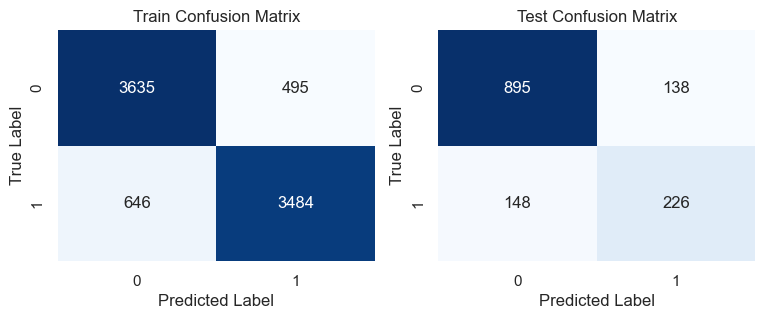

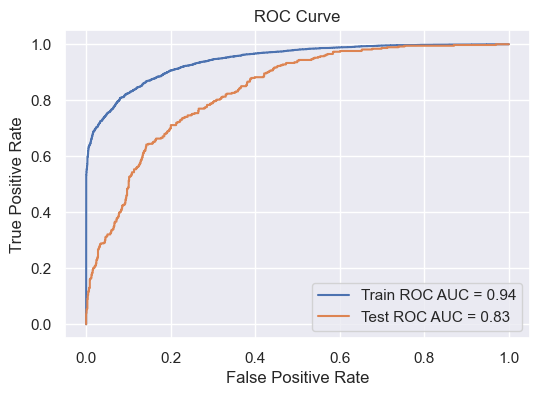

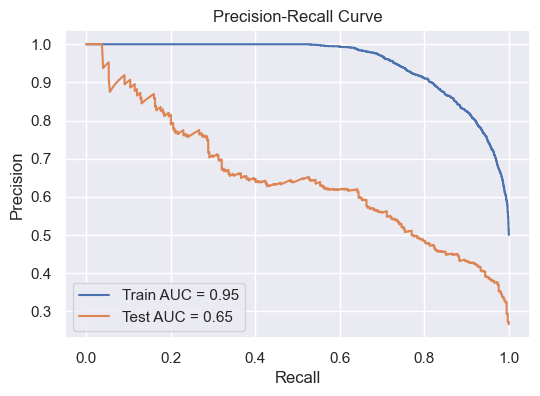

In [56]:
evaluate_model(best_model, X_tr_smote_minmax, y_tr_smote, X_te_smote_minmax, y_te_smote)

**Observation:** 

    1. We can see that model is overfitting on minority class 1 in classification report.
    2. Model is overfitting as seen in roc_auc curve and PR-curve

**Lets check logistic regression with imbalanced data minmax scaled (2nd top model)**

In [64]:
best_model, best_score = tune_model('grid', model, param_grid, X_tr_imb_minmax, y_tr_imb, scoring=['accuracy','f1'], n_iter=10, cv=5, random_state=42)
print('Best model parameters:', best_model.get_params())
print('\n')
print('Best score:', best_score)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best model parameters: {'C': 0.001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'none', 'random_state': None, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Best score: 0.8056888888888889


micro f1_score- train_f1_micro: 0.8101 test_f1_micro: 0.7974 

Classification Report on train data:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      4130
           1       0.68      0.55      0.61      1495

    accuracy                           0.81      5625
   macro avg       0.76      0.73      0.74      5625
weighted avg       0.80      0.81      0.80      5625
 

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      1033
           1       0.64      0.54      0.59       374

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407





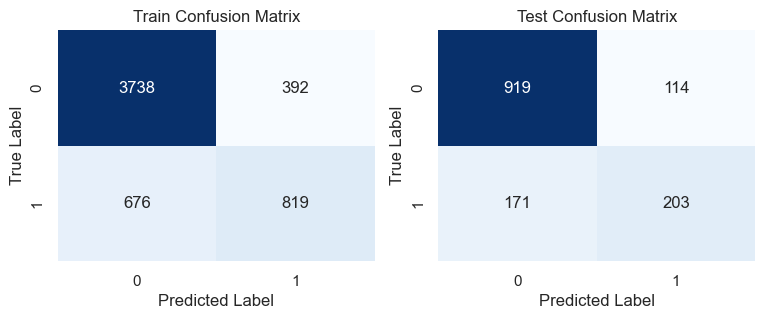

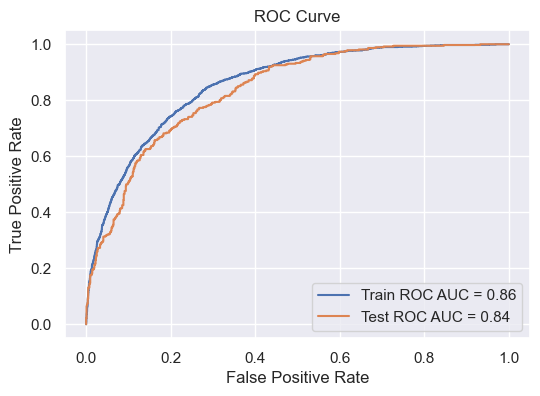

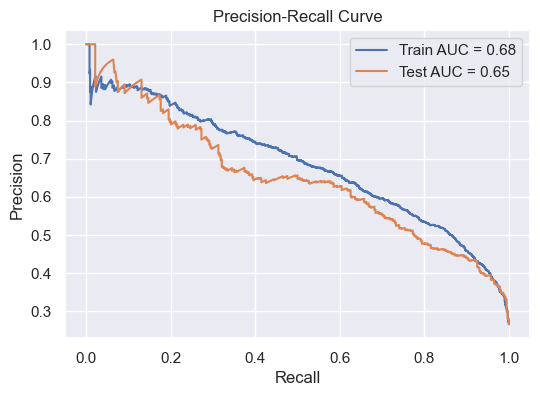

In [66]:
evaluate_model(best_model, X_tr_imb_minmax, y_tr_imb, X_te_imb_minmax, y_te_imb)

**Observation:** model is correct fit. Lets use this model

#### Final Model and feature set selected

In [73]:
with open(r'.\final_model\train_data.pkl', 'wb') as f:
    pickle.dump([X_tr_imb_minmax, y_tr_imb], f)

with open(r'.\final_model\test_data.pkl', 'wb') as f:
    pickle.dump([X_te_imb_minmax, y_te_imb], f)

with open(r'.\final_model\final_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

best_model.get_params()

{'C': 0.001,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': None,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

#### Feature Importance

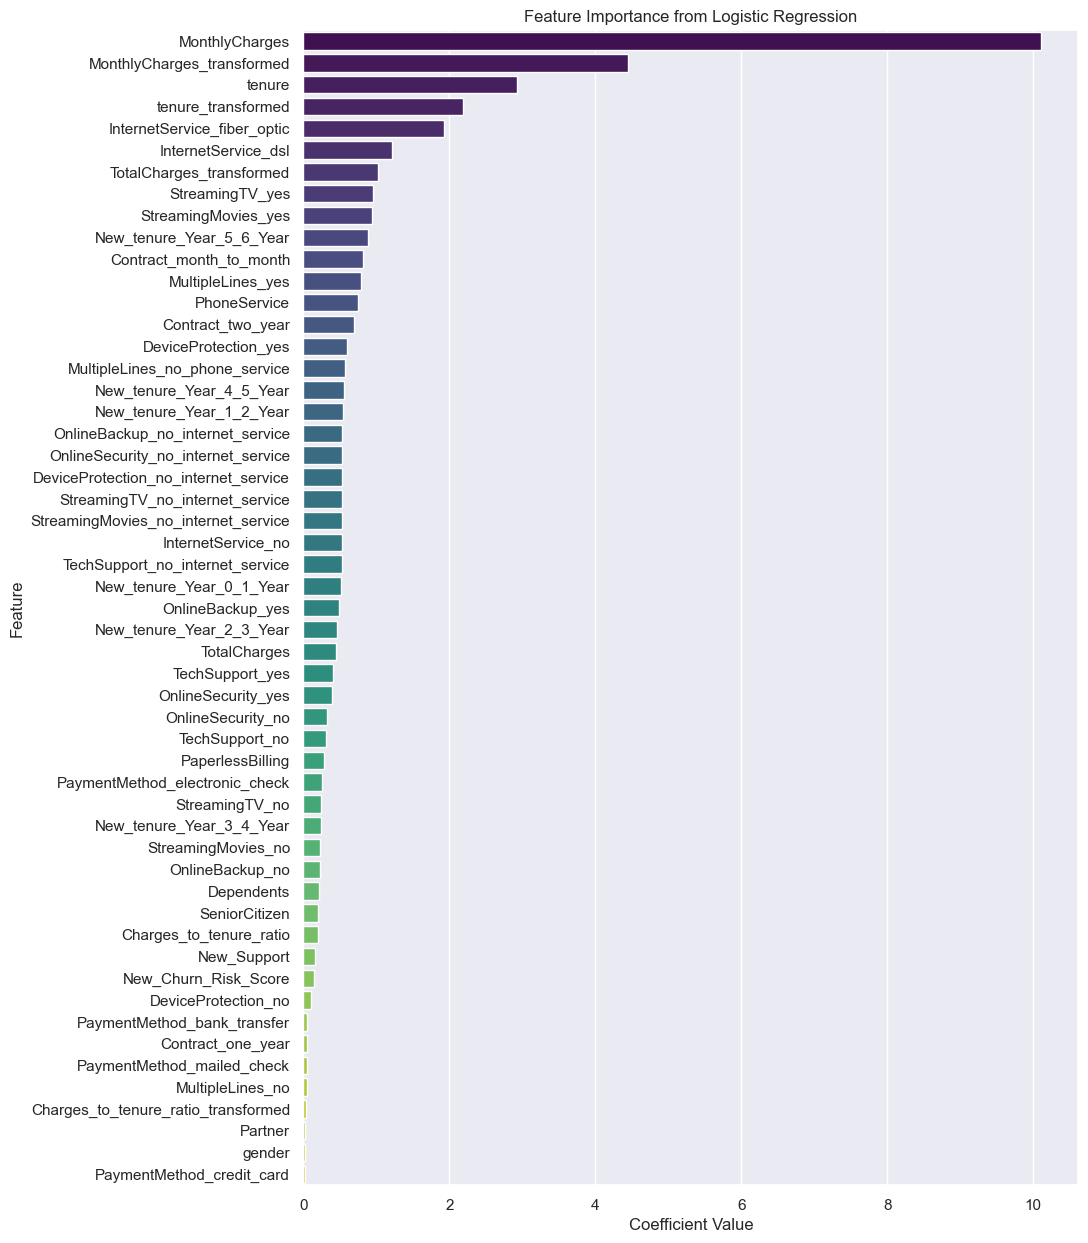

In [75]:
# Extract coefficients and feature names
coefficients = best_model.coef_[0]  # For binary classification, use [0]; for multi-class, you might need to adjust
feature_names = X_tr_smote_minmax.columns

# Create a DataFrame for better visualization
import pandas as pd
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort features by absolute value of coefficient
feature_importance['Absolute Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)

# Plot
plt.figure(figsize=(10, 15))
sns.barplot(data=feature_importance, y='Feature', x='Absolute Coefficient', palette='viridis')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance from Logistic Regression')
plt.show()

#### Fine Tune

Text(0.5, 1.0, 'Absolute Correlation Matrix')

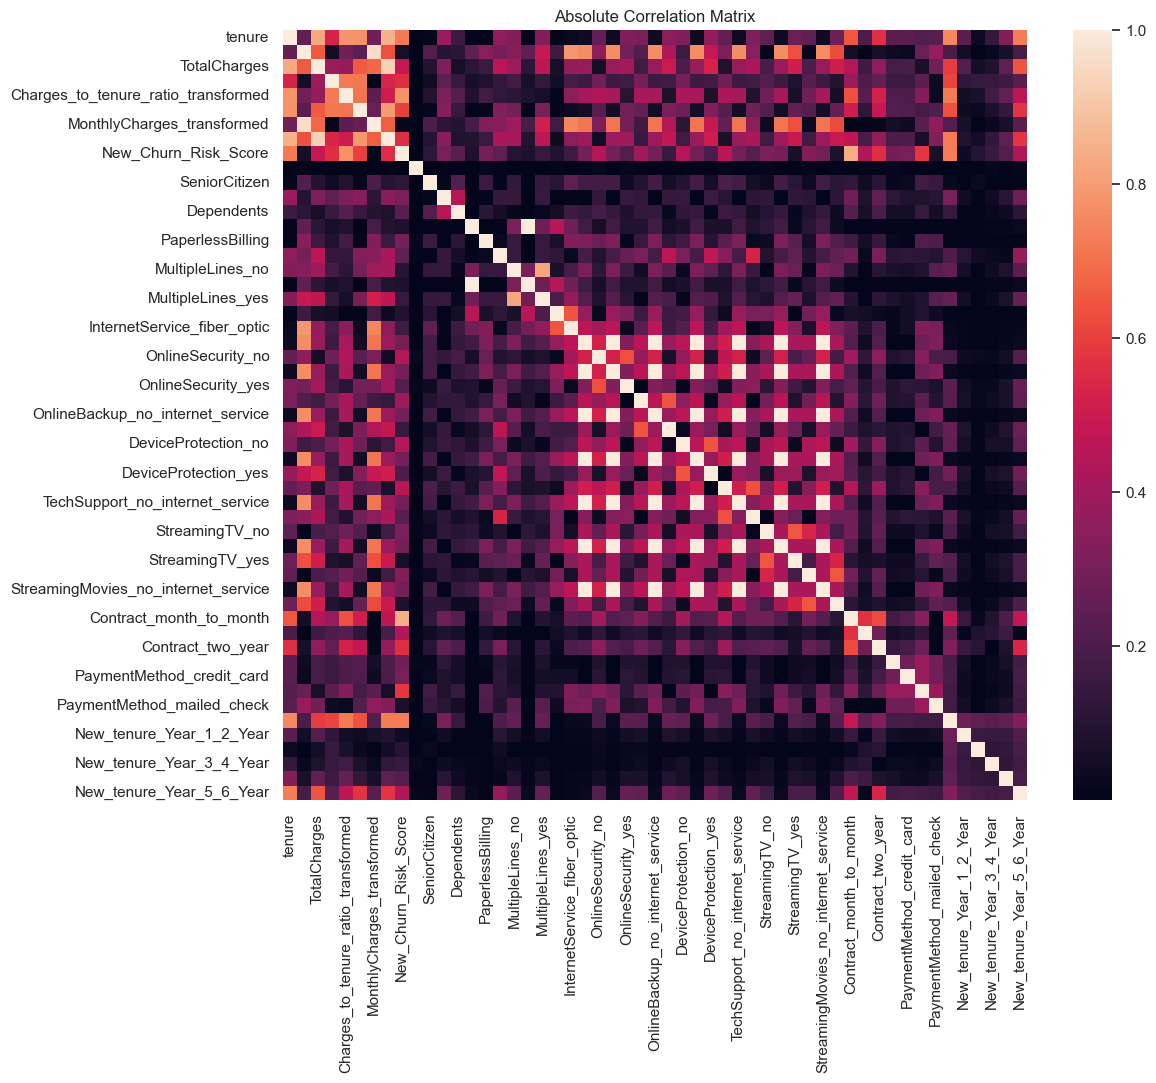

In [107]:
corr_matrix = X_tr_imb_minmax.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.abs())
plt.title('Absolute Correlation Matrix')

**Below features high correlation >0.9**

In [109]:
# Set a threshold for high correlation
threshold = 0.9
to_remove = set()

# Identify features to remove
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            to_remove.add(colname)

print("Features to remove:", to_remove)

Features to remove: {'StreamingMovies_no_internet_service', 'TechSupport_no_internet_service', 'TotalCharges_transformed', 'MonthlyCharges_transformed', 'OnlineBackup_no_internet_service', 'StreamingTV_no_internet_service', 'DeviceProtection_no_internet_service', 'OnlineSecurity_no_internet_service', 'MultipleLines_no_phone_service'}


In [113]:
# Remove the identified features
X_tr_imb_minmax_reduced = X_tr_imb_minmax.drop(columns=to_remove)
X_te_imb_minmax_reduced = X_te_imb_minmax.drop(columns=to_remove)

print("Original feature set:", X_tr_imb_minmax.columns)
print("Reduced feature set:", X_tr_imb_minmax_reduced.columns)

Original feature set: Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'Charges_to_tenure_ratio',
       'Charges_to_tenure_ratio_transformed', 'tenure_transformed',
       'MonthlyCharges_transformed', 'TotalCharges_transformed',
       'New_Churn_Risk_Score', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'PhoneService', 'PaperlessBilling', 'New_Support',
       'MultipleLines_no', 'MultipleLines_no_phone_service',
       'MultipleLines_yes', 'InternetService_dsl',
       'InternetService_fiber_optic', 'InternetService_no',
       'OnlineSecurity_no', 'OnlineSecurity_no_internet_service',
       'OnlineSecurity_yes', 'OnlineBackup_no',
       'OnlineBackup_no_internet_service', 'OnlineBackup_yes',
       'DeviceProtection_no', 'DeviceProtection_no_internet_service',
       'DeviceProtection_yes', 'TechSupport_no',
       'TechSupport_no_internet_service', 'TechSupport_yes', 'StreamingTV_no',
       'StreamingTV_no_internet_service', 'StreamingTV_yes',
       'StreamingM

In [115]:
best_model, best_score = tune_model('grid', model, param_grid, X_tr_imb_minmax_reduced, y_tr_imb, scoring=['accuracy','f1'], n_iter=10, cv=5, random_state=42)

print('Best model parameters:', best_model.get_params())
print('\n')
print('Best score:', best_score)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best model parameters: {'C': 100, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Best score: 0.8056888888888889


In [117]:
with open(r'.\final_model\train_data_reduced_features.pkl', 'wb') as f:
    pickle.dump([X_tr_imb_minmax_reduced, y_tr_imb], f)

with open(r'.\final_model\test_data_reduced_features.pkl', 'wb') as f:
    pickle.dump([X_te_imb_minmax_reduced, y_te_imb], f)

with open(r'.\final_model\final_model_for_reduced_features.pkl', 'wb') as f:
    pickle.dump(best_model, f)

best_model.get_params()

{'C': 100,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

micro f1_score- train_f1_micro: 0.8098 test_f1_micro: 0.8003 

Classification Report on train data:
               precision    recall  f1-score   support

           0       0.85      0.91      0.87      4130
           1       0.68      0.55      0.60      1495

    accuracy                           0.81      5625
   macro avg       0.76      0.73      0.74      5625
weighted avg       0.80      0.81      0.80      5625
 

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      1033
           1       0.65      0.55      0.59       374

    accuracy                           0.80      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407





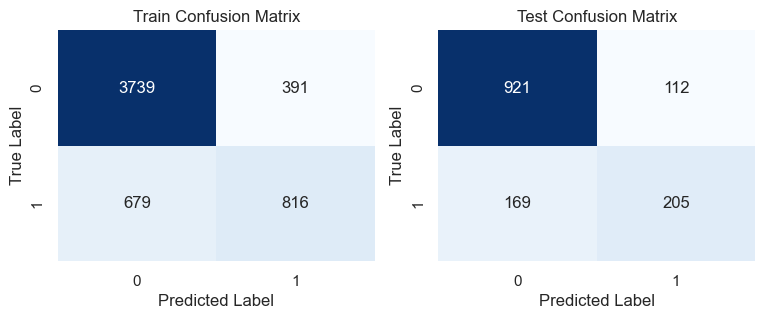

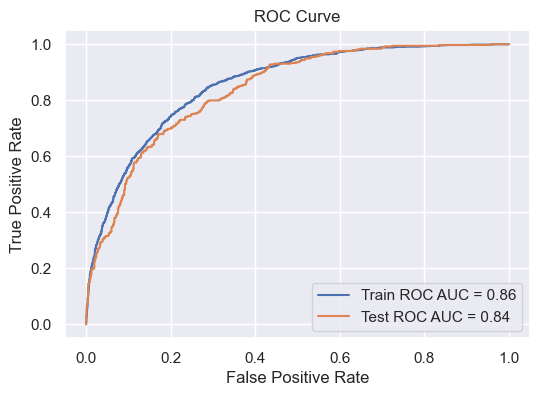

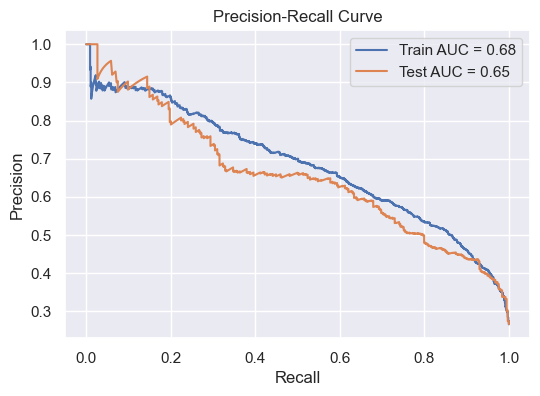

In [119]:
evaluate_model(best_model, X_tr_imb_minmax_reduced, y_tr_imb, X_te_imb_minmax_reduced, y_te_imb)

**Observation:** We can see that micro-f1 score improved slightly

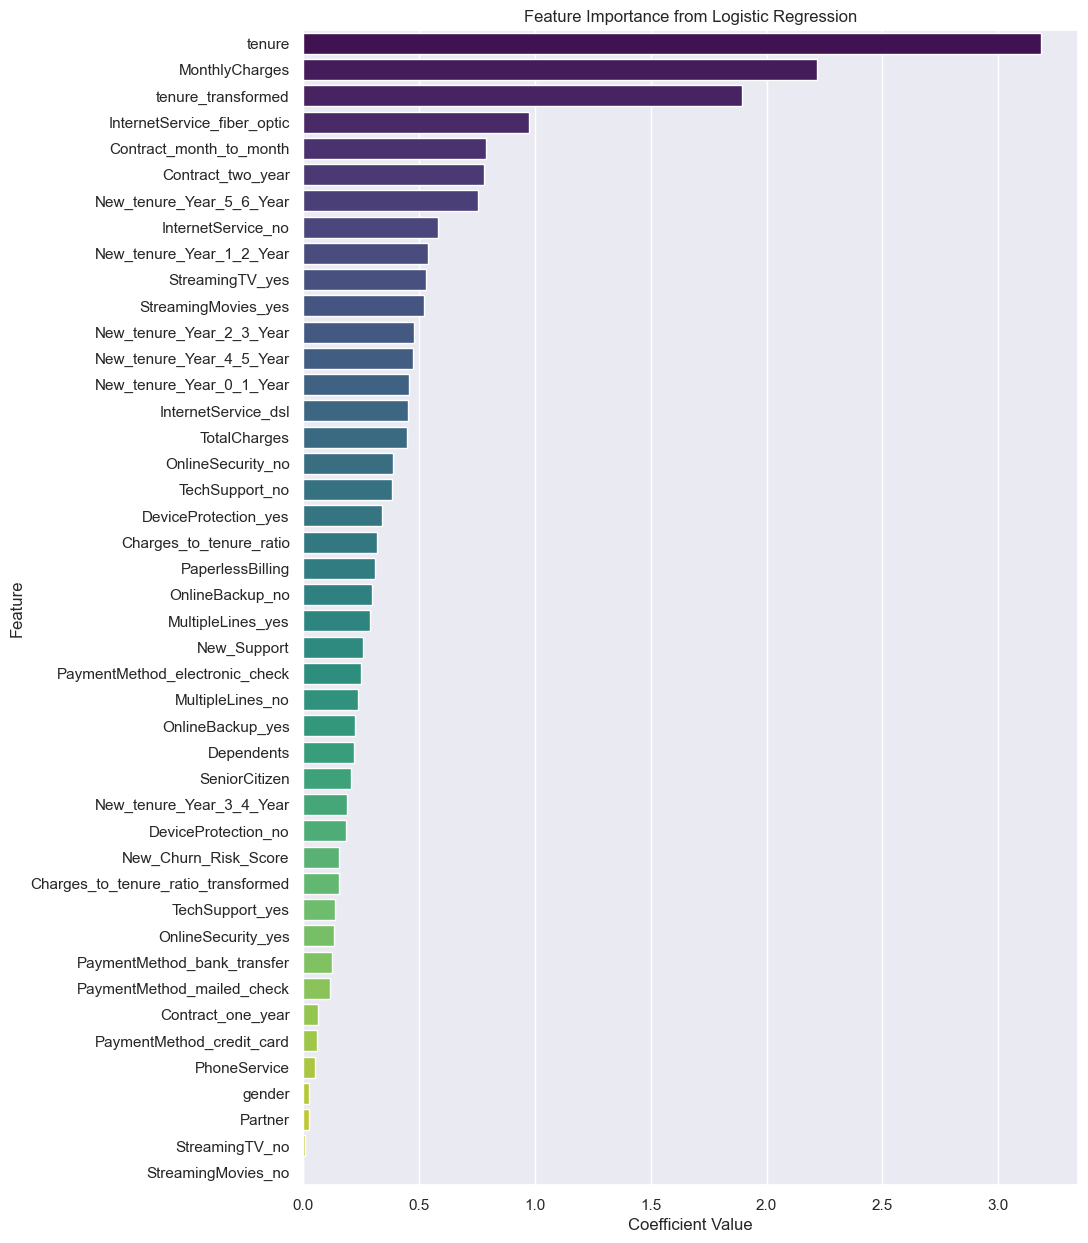

In [121]:
# Extract coefficients and feature names
coefficients = best_model.coef_[0]  # For binary classification, use [0]; for multi-class, you might need to adjust
feature_names = X_tr_imb_minmax_reduced.columns

# Create a DataFrame for better visualization
import pandas as pd
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort features by absolute value of coefficient
feature_importance['Absolute Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)

# Plot
plt.figure(figsize=(10, 15))
sns.barplot(data=feature_importance, y='Feature', x='Absolute Coefficient', palette='viridis')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance from Logistic Regression')
plt.show()

In [123]:
feature_importance['%age_explanability'] = round(feature_importance['Absolute Coefficient'] / feature_importance['Absolute Coefficient'].sum() * 100,2)

In [125]:
print("Top 10 features:")
feature_importance[:10]

Top 10 features:


,Feature,Coefficient,Absolute Coefficient,%age_explanability
0,tenure,-3.184298,3.184298,15.71
1,MonthlyCharges,-2.216396,2.216396,10.94
5,tenure_transformed,-1.894668,1.894668,9.35
17,InternetService_fiber_optic,0.976283,0.976283,4.82
31,Contract_month_to_month,0.791284,0.791284,3.90
33,Contract_two_year,-0.781964,0.781964,3.86
43,New_tenure_Year_5_6_Year,0.756591,0.756591,3.73
18,InternetService_no,-0.580637,0.580637,2.87
39,New_tenure_Year_1_2_Year,-0.538730,0.538730,2.66
28,StreamingTV_yes,0.532349,0.532349,2.63


Text(0.5, 1.0, 'Absolute Correlation Matrix')

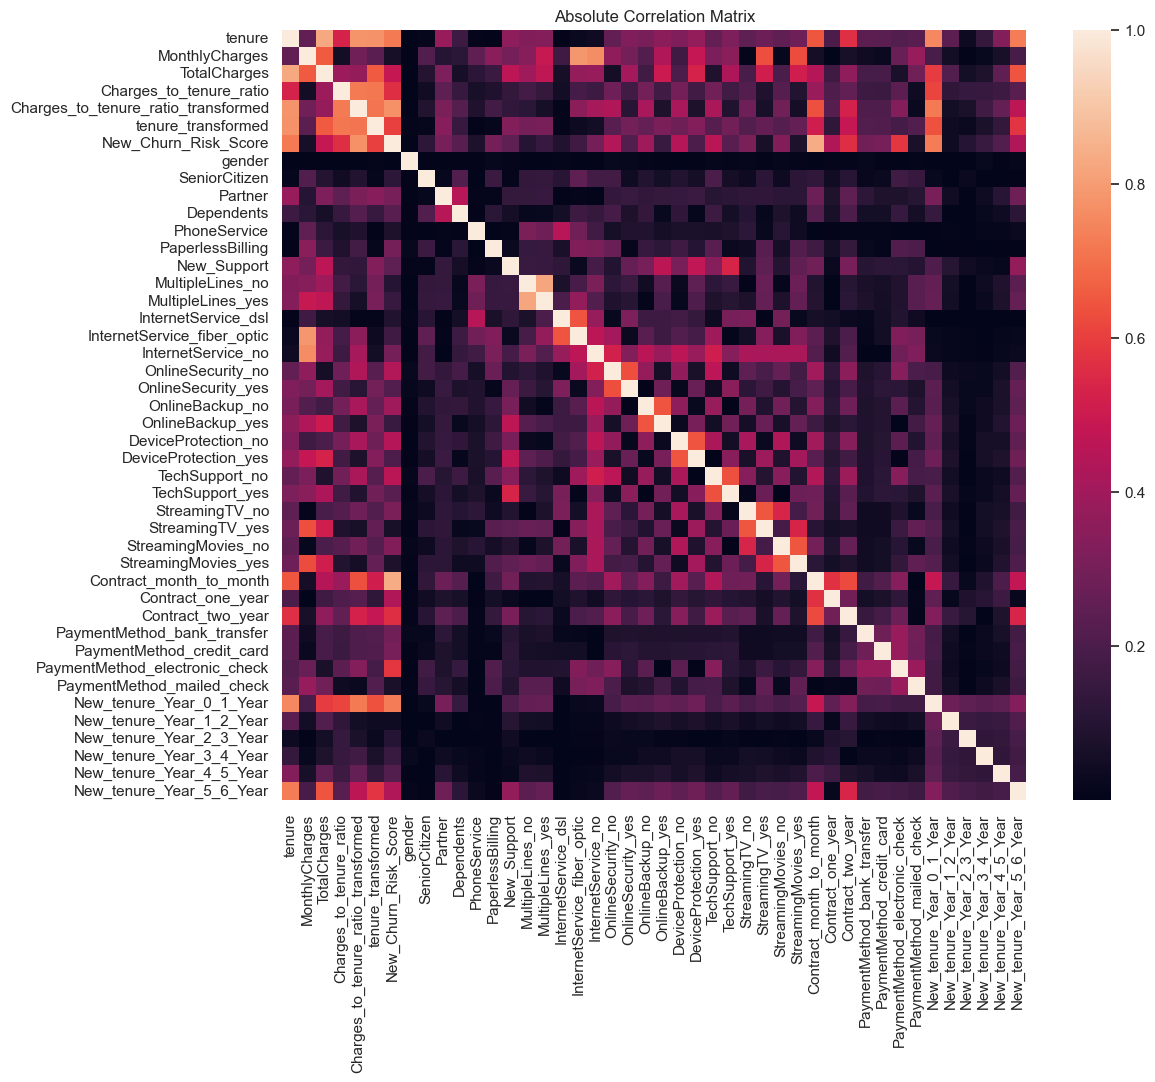

In [127]:
corr_matrix = X_tr_imb_minmax_reduced.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.abs())
plt.title('Absolute Correlation Matrix')

**Observation:** No correlation

### Final Model Details

In [143]:
print('final model parameters: Logistic Regression', best_model.get_params())

final model parameters: Logistic Regression {'C': 100, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [137]:
print('Final features selected:', X_tr_imb_minmax_reduced.columns)

Final features selected: Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'Charges_to_tenure_ratio',
       'Charges_to_tenure_ratio_transformed', 'tenure_transformed',
       'New_Churn_Risk_Score', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'PhoneService', 'PaperlessBilling', 'New_Support',
       'MultipleLines_no', 'MultipleLines_yes', 'InternetService_dsl',
       'InternetService_fiber_optic', 'InternetService_no',
       'OnlineSecurity_no', 'OnlineSecurity_yes', 'OnlineBackup_no',
       'OnlineBackup_yes', 'DeviceProtection_no', 'DeviceProtection_yes',
       'TechSupport_no', 'TechSupport_yes', 'StreamingTV_no',
       'StreamingTV_yes', 'StreamingMovies_no', 'StreamingMovies_yes',
       'Contract_month_to_month', 'Contract_one_year', 'Contract_two_year',
       'PaymentMethod_bank_transfer', 'PaymentMethod_credit_card',
       'PaymentMethod_electronic_check', 'PaymentMethod_mailed_check',
       'New_tenure_Year_0_1_Year', 'New_tenure_Year_1_2_Year',
    